# SQLite Database Explorer

This notebook provides comprehensive exploration of the leader-toolbox SQLite database, including:
- Database schema inspection
- Data exploration and statistics
- Foreign key relationship validation
- Text content analysis
- Embedding visualization (if available)

In [1]:
# Required imports
import sqlite3
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("📚 Libraries loaded successfully")

📚 Libraries loaded successfully


In [2]:
# Connect to the SQLite database
DB_PATH = "data/memory.db"

# Check if database exists
if not Path(DB_PATH).exists():
    print(f"❌ Database not found at {DB_PATH}")
    print("Available .db files:")
    for db_file in Path(".").rglob("*.db"):
        print(f"  - {db_file}")
else:
    print(f"✅ Database found at {DB_PATH}")
    db_size = Path(DB_PATH).stat().st_size
    print(f"📊 Database size: {db_size:,} bytes ({db_size/1024/1024:.2f} MB)")

# Connect to database
conn = sqlite3.connect(DB_PATH)
conn.row_factory = sqlite3.Row  # Enable column access by name
cursor = conn.cursor()

print(f"🔗 Connected to SQLite database")

✅ Database found at data/memory.db
📊 Database size: 229,376 bytes (0.22 MB)
🔗 Connected to SQLite database


## 1. Database Schema Inspection

In [3]:
# Get all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = [row[0] for row in cursor.fetchall()]

print(f"📋 Tables in database: {len(tables)}")
for table in tables:
    print(f"  - {table}")

# Get virtual tables (FTS)
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND sql LIKE '%VIRTUAL%'")
virtual_tables = [row[0] for row in cursor.fetchall()]
if virtual_tables:
    print(f"\n🔍 Virtual tables (FTS): {len(virtual_tables)}")
    for table in virtual_tables:
        print(f"  - {table}")

📋 Tables in database: 10
  - meta
  - files
  - chunks
  - sqlite_sequence
  - chunks_fts
  - chunks_fts_data
  - chunks_fts_idx
  - chunks_fts_docsize
  - chunks_fts_config
  - embedding_cache

🔍 Virtual tables (FTS): 1
  - chunks_fts


In [4]:
# Inspect schema for each table
def get_table_info(table_name):
    """Get detailed information about a table."""
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_count = cursor.fetchone()[0]
    
    return columns, row_count

# Display schema for each main table
main_tables = [t for t in tables if not t.startswith('sqlite_') and 'fts' not in t]

for table in main_tables:
    print(f"\n📊 Table: {table}")
    print("=" * 50)
    
    columns, row_count = get_table_info(table)
    print(f"Rows: {row_count:,}")
    print(f"Columns: {len(columns)}")
    
    # Create DataFrame for better display
    schema_df = pd.DataFrame([
        {
            'Column': col[1],
            'Type': col[2],
            'NotNull': bool(col[3]),
            'Default': col[4],
            'PrimaryKey': bool(col[5])
        }
        for col in columns
    ])
    
    display(schema_df)


📊 Table: meta
Rows: 0
Columns: 2


,Column,Type,NotNull,Default,PrimaryKey
0,key,TEXT,False,None,True
1,value,TEXT,True,None,False



📊 Table: files
Rows: 10
Columns: 8


,Column,Type,NotNull,Default,PrimaryKey
0,id,TEXT,False,None,True
1,path,TEXT,True,None,False
2,hash,TEXT,True,None,False
3,size,INTEGER,True,None,False
4,mtime,REAL,True,None,False
5,metadata,TEXT,False,'{}',False
6,created_at,REAL,True,None,False
7,updated_at,REAL,True,None,False



📊 Table: chunks
Rows: 9
Columns: 9


,Column,Type,NotNull,Default,PrimaryKey
0,rowid,INTEGER,False,None,True
1,id,TEXT,True,None,False
2,file_id,TEXT,True,None,False
3,text,TEXT,True,None,False
4,embedding,BLOB,False,None,False
5,start_char,INTEGER,True,None,False
6,end_char,INTEGER,True,None,False
7,metadata,TEXT,False,'{}',False
8,created_at,REAL,True,None,False



📊 Table: embedding_cache
Rows: 14
Columns: 5


,Column,Type,NotNull,Default,PrimaryKey
0,hash,TEXT,False,None,True
1,provider,TEXT,True,None,False
2,model,TEXT,True,None,False
3,embedding,BLOB,True,None,False
4,created_at,REAL,True,None,False


## 2. Foreign Key Relationship Analysis

In [5]:
# Check foreign key constraints
cursor.execute("PRAGMA foreign_keys")
fk_enabled = cursor.fetchone()[0]
print(f"🔐 Foreign keys enabled: {bool(fk_enabled)}")

# Check for foreign key violations
cursor.execute("PRAGMA foreign_key_check")
violations = cursor.fetchall()
print(f"⚠️  Foreign key violations: {len(violations)}")

if violations:
    print("\nViolations found:")
    for violation in violations:
        print(f"  - {violation}")
else:
    print("✅ No foreign key violations found")

🔐 Foreign keys enabled: False
⚠️  Foreign key violations: 0
✅ No foreign key violations found


In [6]:
# Analyze file-chunk relationships
print("📁 File-Chunk Relationship Analysis")
print("=" * 40)

# Files without chunks
cursor.execute("""
    SELECT f.id, f.path, f.created_at
    FROM files f
    LEFT JOIN chunks c ON f.id = c.file_id
    WHERE c.file_id IS NULL
""")
orphaned_files = cursor.fetchall()
print(f"Files without chunks: {len(orphaned_files)}")

# Chunks without files
cursor.execute("""
    SELECT c.id, c.file_id, c.created_at
    FROM chunks c
    LEFT JOIN files f ON c.file_id = f.id
    WHERE f.id IS NULL
""")
orphaned_chunks = cursor.fetchall()
print(f"Chunks without files: {len(orphaned_chunks)}")

# Files with chunk counts
cursor.execute("""
    SELECT 
        f.id,
        f.path,
        COUNT(c.id) as chunk_count,
        f.size as file_size,
        datetime(f.created_at, 'unixepoch') as created_at
    FROM files f
    LEFT JOIN chunks c ON f.id = c.file_id
    GROUP BY f.id, f.path, f.size, f.created_at
    ORDER BY chunk_count DESC
""")
file_chunks = cursor.fetchall()

if file_chunks:
    files_df = pd.DataFrame([
        {
            'File ID': row[0][:8] + '...',
            'Path': Path(row[1]).name,
            'Chunks': row[2],
            'Size (bytes)': row[3],
            'Created': row[4]
        }
        for row in file_chunks
    ])
    
    print(f"\n📋 Files and their chunk counts:")
    display(files_df)
else:
    print("\n📭 No files found in database")

📁 File-Chunk Relationship Analysis
Files without chunks: 1
Chunks without files: 0

📋 Files and their chunk counts:


,File ID,Path,Chunks,Size (bytes),Created
0,7a9852a4...,clean_test.md,1,56,2026-02-14 16:35:58
1,ce0a56b6...,fastapi_tutorial.md,1,498,2026-02-14 16:37:10
2,a366e23b...,ml_concepts.md,1,497,2026-02-14 16:37:10
3,1cf2d3ec...,text_1cf2d3ec-369c-4c28-be7e-657114abaf15,1,225,2026-02-15 06:43:30
4,8b45144d...,text_8b45144d-5529-41ed-b29b-a358fa34cdf4,1,195,2026-02-14 16:37:10
5,abd2b58d...,text_abd2b58d-c43b-48d3-bb3a-c381a11fc9f4,1,194,2026-02-15 06:43:30
6,bfa59012...,text_bfa59012-9f81-4711-81a7-10668b5fabd3,1,195,2026-02-15 06:43:30
7,cea7a75a...,text_cea7a75a-3bc2-4ce3-8427-5cd9800e5763,1,225,2026-02-14 16:37:10
8,ee59d5f3...,text_ee59d5f3-0bdb-4358-87c9-155147ceafb5,1,194,2026-02-14 16:37:10
9,38002564...,python_guide.md,0,493,2026-02-14 16:37:10


## 3. Data Content Analysis

📊 Database Statistics
meta        : 0 records
files       : 10 records
chunks      : 9 records
embedding_cache: 14 records


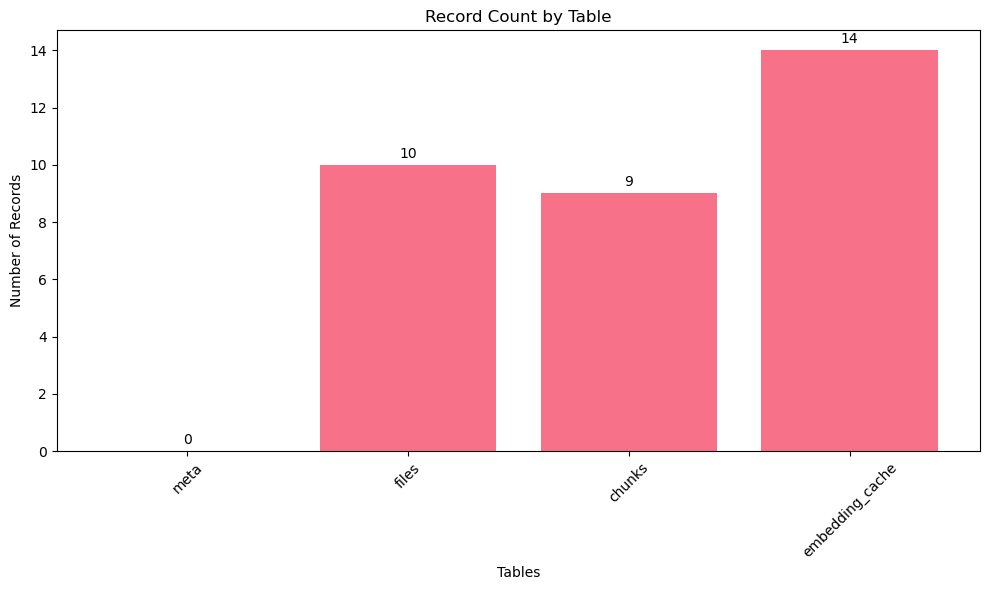

In [7]:
# Overall statistics
stats = {}

for table in main_tables:
    cursor.execute(f"SELECT COUNT(*) FROM {table}")
    stats[table] = cursor.fetchone()[0]

print("📊 Database Statistics")
print("=" * 30)
for table, count in stats.items():
    print(f"{table:12}: {count:,} records")

# Create a simple bar chart
if any(count > 0 for count in stats.values()):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    tables_list = list(stats.keys())
    counts_list = list(stats.values())
    
    bars = ax.bar(tables_list, counts_list)
    ax.set_title('Record Count by Table')
    ax.set_ylabel('Number of Records')
    ax.set_xlabel('Tables')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts_list):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(counts_list)*0.01,
                f'{count:,}', ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
# Analyze metadata if available
if 'meta' in stats and stats['meta'] > 0:
    print("🔧 Metadata Analysis")
    print("=" * 20)
    
    cursor.execute("SELECT key, value FROM meta")
    meta_rows = cursor.fetchall()
    
    for row in meta_rows:
        key, value = row[0], row[1]
        try:
            # Try to parse JSON values
            parsed_value = json.loads(value)
            print(f"{key}: {parsed_value}")
        except:
            print(f"{key}: {value}")
else:
    print("📭 No metadata found")

📭 No metadata found


📁 Files Analysis
Total files: 10
Total size: 2,772 bytes
Average size: 277.2 bytes


,Path,Size (bytes),Created,Updated,Metadata
0,text_bfa59012-9f81-4711-81a7-10668b5fabd3,195,2026-02-15 06:43:30,2026-02-15 06:43:30,"{""type"": ""text"", ""title"": ""Python Introduction..."
1,text_1cf2d3ec-369c-4c28-be7e-657114abaf15,225,2026-02-15 06:43:30,2026-02-15 06:43:30,"{""type"": ""text"", ""title"": ""Machine Learning Ba..."
2,text_abd2b58d-c43b-48d3-bb3a-c381a11fc9f4,194,2026-02-15 06:43:30,2026-02-15 06:43:30,"{""type"": ""text"", ""title"": ""FastAPI Overview"", ..."
3,text_8b45144d-5529-41ed-b29b-a358fa34cdf4,195,2026-02-14 16:37:10,2026-02-14 16:37:10,"{""type"": ""text"", ""title"": ""Python Introduction..."
4,text_cea7a75a-3bc2-4ce3-8427-5cd9800e5763,225,2026-02-14 16:37:10,2026-02-14 16:37:10,"{""type"": ""text"", ""title"": ""Machine Learning Ba..."


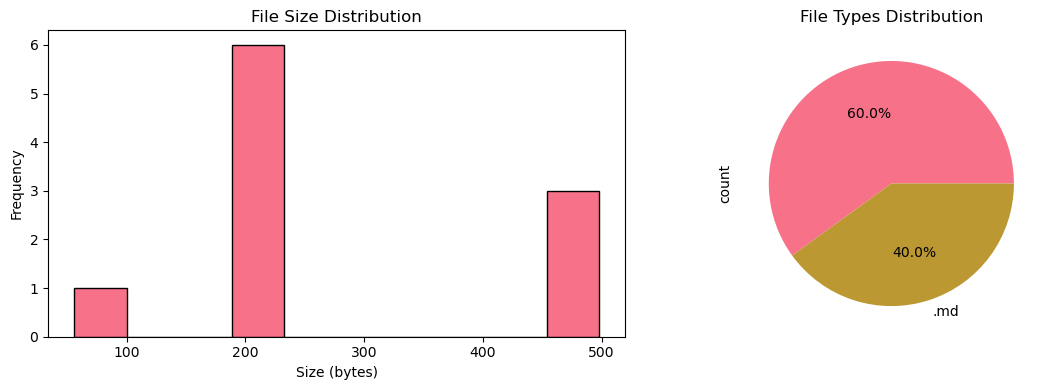

In [9]:
# Analyze files data
if 'files' in stats and stats['files'] > 0:
    print("📁 Files Analysis")
    print("=" * 20)
    
    # Get file data
    cursor.execute("""
        SELECT 
            path, 
            size, 
            datetime(created_at, 'unixepoch') as created_at,
            datetime(updated_at, 'unixepoch') as updated_at,
            metadata
        FROM files 
        ORDER BY created_at DESC
    """)
    files_data = cursor.fetchall()
    
    files_df = pd.DataFrame([
        {
            'Path': row[0],
            'Size (bytes)': row[1],
            'Created': row[2],
            'Updated': row[3],
            'Metadata': row[4]
        }
        for row in files_data
    ])
    
    print(f"Total files: {len(files_df)}")
    print(f"Total size: {files_df['Size (bytes)'].sum():,} bytes")
    print(f"Average size: {files_df['Size (bytes)'].mean():.1f} bytes")
    
    display(files_df.head())
    
    # File size distribution
    if len(files_df) > 1:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(files_df['Size (bytes)'], bins=min(20, len(files_df)), edgecolor='black')
        plt.title('File Size Distribution')
        plt.xlabel('Size (bytes)')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        file_extensions = [Path(path).suffix.lower() for path in files_df['Path']]
        ext_counts = pd.Series(file_extensions).value_counts()
        ext_counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title('File Types Distribution')
        
        plt.tight_layout()
        plt.show()
else:
    print("📭 No files found")

📝 Chunks Analysis
Total chunks: 9
Chunks with embeddings: 9
Average text length: 253.8 characters
Total text: 2,284 characters


,Chunk ID,File ID,Text Length,Start Char,End Char,Has Embedding,Created,File Path
0,6fca1326...,abd2b58d...,194,0,194,1,2026-02-15 06:43:30,text_abd2b58d-c43b-48d3-bb3a-c381a11fc9f4
1,44b5cd34...,1cf2d3ec...,225,0,225,1,2026-02-15 06:43:30,text_1cf2d3ec-369c-4c28-be7e-657114abaf15
2,50f30b8b...,bfa59012...,195,0,195,1,2026-02-15 06:43:30,text_bfa59012-9f81-4711-81a7-10668b5fabd3
3,1bde3119...,ce0a56b6...,500,0,501,1,2026-02-14 16:37:10,fastapi_tutorial.md
4,ce06d855...,a366e23b...,499,0,500,1,2026-02-14 16:37:10,ml_concepts.md


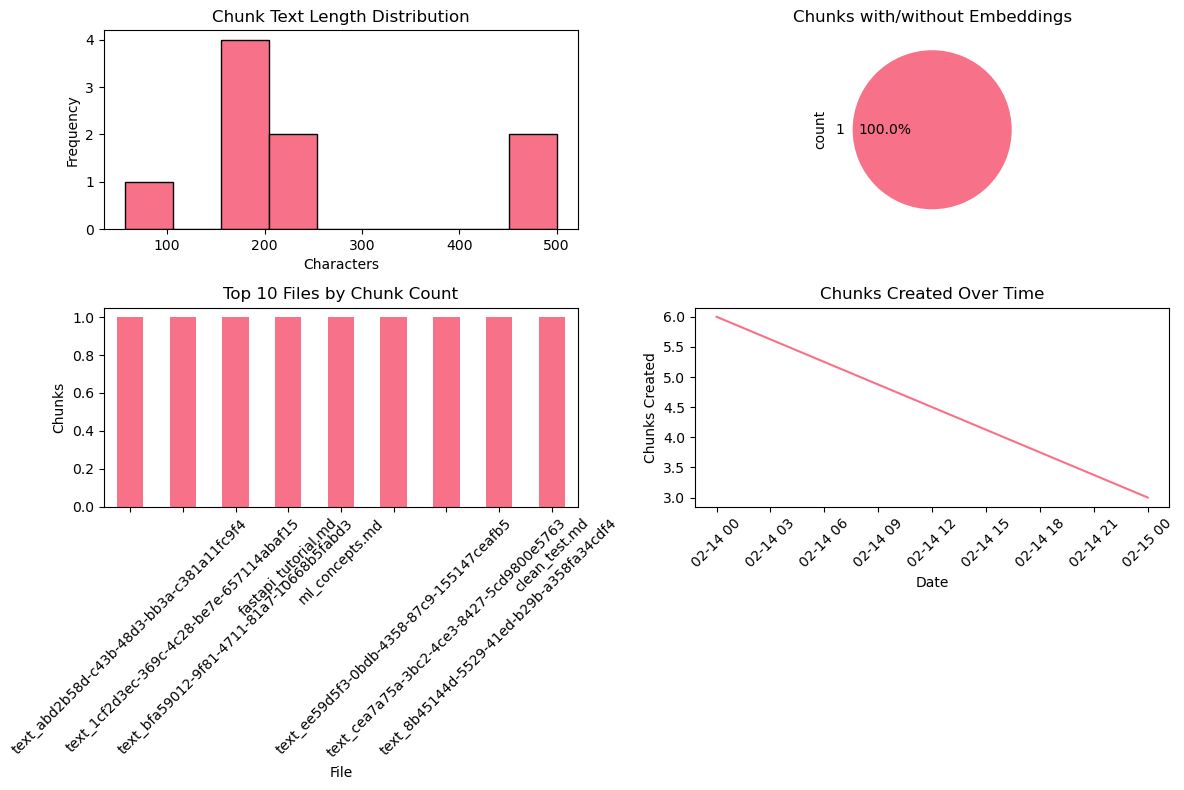

In [10]:
# Analyze chunks data
if 'chunks' in stats and stats['chunks'] > 0:
    print("📝 Chunks Analysis")
    print("=" * 20)
    
    # Get chunk data
    cursor.execute("""
        SELECT 
            c.id,
            c.file_id,
            LENGTH(c.text) as text_length,
            c.start_char,
            c.end_char,
            c.embedding IS NOT NULL as has_embedding,
            datetime(c.created_at, 'unixepoch') as created_at,
            f.path as file_path
        FROM chunks c
        LEFT JOIN files f ON c.file_id = f.id
        ORDER BY c.created_at DESC
    """)
    chunks_data = cursor.fetchall()
    
    chunks_df = pd.DataFrame([
        {
            'Chunk ID': row[0][:8] + '...',
            'File ID': row[1][:8] + '...' if row[1] else None,
            'Text Length': row[2],
            'Start Char': row[3],
            'End Char': row[4],
            'Has Embedding': row[5],
            'Created': row[6],
            'File Path': Path(row[7]).name if row[7] else 'Unknown'
        }
        for row in chunks_data
    ])
    
    print(f"Total chunks: {len(chunks_df)}")
    print(f"Chunks with embeddings: {chunks_df['Has Embedding'].sum()}")
    print(f"Average text length: {chunks_df['Text Length'].mean():.1f} characters")
    print(f"Total text: {chunks_df['Text Length'].sum():,} characters")
    
    display(chunks_df.head())
    
    # Text length distribution
    if len(chunks_df) > 1:
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        plt.hist(chunks_df['Text Length'], bins=min(30, len(chunks_df)), edgecolor='black')
        plt.title('Chunk Text Length Distribution')
        plt.xlabel('Characters')
        plt.ylabel('Frequency')
        
        plt.subplot(2, 2, 2)
        embedding_counts = chunks_df['Has Embedding'].value_counts()
        embedding_counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Chunks with/without Embeddings')
        
        plt.subplot(2, 2, 3)
        chunks_per_file = chunks_df['File Path'].value_counts().head(10)
        chunks_per_file.plot(kind='bar')
        plt.title('Top 10 Files by Chunk Count')
        plt.xlabel('File')
        plt.ylabel('Chunks')
        plt.xticks(rotation=45)
        
        plt.subplot(2, 2, 4)
        # Timeline of chunk creation
        chunks_df['Created'] = pd.to_datetime(chunks_df['Created'])
        daily_chunks = chunks_df.groupby(chunks_df['Created'].dt.date).size()
        daily_chunks.plot()
        plt.title('Chunks Created Over Time')
        plt.xlabel('Date')
        plt.ylabel('Chunks Created')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
else:
    print("📭 No chunks found")

## 4. Text Content Exploration

In [11]:
# Sample chunk texts
if 'chunks' in stats and stats['chunks'] > 0:
    print("📖 Text Content Samples")
    print("=" * 30)
    
    # Get some sample chunks with their text
    cursor.execute("""
        SELECT 
            c.text,
            LENGTH(c.text) as length,
            f.path as file_path
        FROM chunks c
        LEFT JOIN files f ON c.file_id = f.id
        ORDER BY RANDOM()
        LIMIT 5
    """)
    sample_chunks = cursor.fetchall()
    
    for i, chunk in enumerate(sample_chunks, 1):
        text, length, file_path = chunk[0], chunk[1], chunk[2]
        file_name = Path(file_path).name if file_path else "Unknown"
        
        print(f"\n📄 Sample {i} - {file_name} ({length} chars)")
        print("-" * 60)
        # Show first 300 characters
        preview = text[:300] + "..." if len(text) > 300 else text
        print(preview)
        
    # Word frequency analysis (simple)
    print(f"\n🔤 Text Analysis Summary")
    print("=" * 30)
    
    cursor.execute("SELECT text FROM chunks")
    all_texts = [row[0] for row in cursor.fetchall()]
    
    if all_texts:
        combined_text = " ".join(all_texts)
        words = combined_text.lower().split()
        
        print(f"Total words: {len(words):,}")
        print(f"Unique words: {len(set(words)):,}")
        print(f"Average words per chunk: {len(words) / len(all_texts):.1f}")
        
        # Most common words (excluding very short ones)
        word_freq = {}
        for word in words:
            if len(word) >= 4:  # Only words 4+ characters
                word_freq[word] = word_freq.get(word, 0) + 1
        
        top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
        
        if top_words:
            print(f"\n📈 Top 20 words (4+ characters):")
            for word, count in top_words:
                print(f"  {word:15}: {count:3d}")
else:
    print("📭 No text content to analyze")

📖 Text Content Samples

📄 Sample 1 - ml_concepts.md (499 chars)
------------------------------------------------------------
# Machine Learning Concepts


## Supervised Learning
Algorithms learn from labeled training data to make predictions on new data.
Examples: Linear Regression, Support Vector Machines, Random Forest.


## Unsupervised Learning
Algorithms find patterns in data without labeled examples.
Examples: K-Mea...

📄 Sample 2 - text_8b45144d-5529-41ed-b29b-a358fa34cdf4 (195 chars)
------------------------------------------------------------
Python is a high-level programming language known for its simplicity and readability. It supports multiple programming paradigms including procedural, object-oriented, and functional programming.

📄 Sample 3 - text_cea7a75a-3bc2-4ce3-8427-5cd9800e5763 (225 chars)
------------------------------------------------------------
Machine learning is a subset of artificial intelligence that enables computers to learn and make decisions without be

## 5. Embedding Analysis

In [12]:
# Analyze embeddings if they exist
if 'chunks' in stats and stats['chunks'] > 0:
    cursor.execute("SELECT COUNT(*) FROM chunks WHERE embedding IS NOT NULL")
    embedding_count = cursor.fetchone()[0]
    
    if embedding_count > 0:
        print(f"🧠 Embedding Analysis")
        print("=" * 20)
        print(f"Chunks with embeddings: {embedding_count}")
        
        # Get a sample embedding to analyze dimension
        cursor.execute("SELECT embedding FROM chunks WHERE embedding IS NOT NULL LIMIT 1")
        sample_embedding = cursor.fetchone()[0]
        
        try:
            # Try to load the embedding (assuming it's pickled numpy array)
            embedding_array = pickle.loads(sample_embedding)
            
            if isinstance(embedding_array, np.ndarray):
                print(f"Embedding dimension: {embedding_array.shape}")
                print(f"Data type: {embedding_array.dtype}")
                print(f"Value range: [{embedding_array.min():.4f}, {embedding_array.max():.4f}]")
                print(f"Mean: {embedding_array.mean():.4f}")
                print(f"Std: {embedding_array.std():.4f}")
                
                # If 2D embedding space, try to visualize a sample
                if len(embedding_array.shape) == 1 and len(embedding_array) >= 2:
                    # Get multiple embeddings for visualization
                    cursor.execute("""
                        SELECT embedding, text 
                        FROM chunks 
                        WHERE embedding IS NOT NULL 
                        LIMIT 50
                    """)
                    embedding_data = cursor.fetchall()
                    
                    if len(embedding_data) > 10:
                        embeddings = []
                        texts = []
                        
                        for row in embedding_data:
                            emb = pickle.loads(row[0])
                            if isinstance(emb, np.ndarray) and len(emb) >= 2:
                                embeddings.append(emb)
                                texts.append(row[1][:50] + '...')  # First 50 chars
                        
                        if len(embeddings) > 5:
                            embeddings = np.array(embeddings)
                            
                            # Simple 2D projection using first two dimensions
                            plt.figure(figsize=(12, 8))
                            plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.6)
                            plt.title('Embedding Visualization (First 2 Dimensions)')
                            plt.xlabel('Dimension 1')
                            plt.ylabel('Dimension 2')
                            
                            # Add text labels for a few points
                            for i in range(min(10, len(texts))):
                                plt.annotate(texts[i][:20], 
                                           (embeddings[i, 0], embeddings[i, 1]),
                                           fontsize=8, alpha=0.7)
                            
                            plt.tight_layout()
                            plt.show()
            
        except Exception as e:
            print(f"Could not analyze embedding format: {e}")
            print(f"Embedding size: {len(sample_embedding)} bytes")
    else:
        print("🧠 No embeddings found in database")
else:
    print("📭 No chunks to analyze for embeddings")

🧠 Embedding Analysis
Chunks with embeddings: 9
Could not analyze embedding format: pickle data was truncated
Embedding size: 1536 bytes


## 6. Data Export Options

In [13]:
# Provide data export functionality
print("💾 Data Export Options")
print("=" * 25)

def export_table_to_csv(table_name, output_dir="exports"):
    """Export a table to CSV format."""
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Get all data from table
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    
    # Save to CSV
    output_file = output_dir / f"{table_name}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"✅ Exported {table_name} to {output_file} ({len(df)} rows)")
    return output_file

def export_all_data():
    """Export all tables to CSV files."""
    print("Exporting all tables...")
    export_files = []
    
    for table in main_tables:
        if stats.get(table, 0) > 0:
            output_file = export_table_to_csv(table)
            export_files.append(output_file)
    
    return export_files

# Example usage:
print("To export data, run:")
print("  export_files = export_all_data()")
print("  # or for individual tables:")
print("  export_table_to_csv('files')")
print("  export_table_to_csv('chunks')")

# Uncomment the next line to actually export all data
# export_files = export_all_data()

💾 Data Export Options
To export data, run:
  export_files = export_all_data()
  # or for individual tables:
  export_table_to_csv('files')
  export_table_to_csv('chunks')


## 7. Custom Queries

In [14]:
# Custom query function for interactive exploration
def run_query(sql_query, description=""):
    """Execute a custom SQL query and display results."""
    try:
        df = pd.read_sql_query(sql_query, conn)
        
        if description:
            print(f"📊 {description}")
            print("=" * len(description))
        
        print(f"Query returned {len(df)} rows")
        if len(df) > 0:
            display(df)
        else:
            print("No results found")
            
        return df
        
    except Exception as e:
        print(f"❌ Error executing query: {e}")
        return None

# Example queries
print("🔍 Example Custom Queries")
print("=" * 30)
print("")

# Example 1: Files with most chunks
query1 = """
SELECT 
    f.path,
    COUNT(c.id) as chunk_count,
    f.size as file_size,
    datetime(f.created_at, 'unixepoch') as created_at
FROM files f
LEFT JOIN chunks c ON f.id = c.file_id
GROUP BY f.id
ORDER BY chunk_count DESC
LIMIT 10
"""

run_query(query1, "Files with most chunks")

# Example 2: Largest chunks
if stats.get('chunks', 0) > 0:
    query2 = """
    SELECT 
        c.id,
        LENGTH(c.text) as text_length,
        SUBSTR(c.text, 1, 100) || '...' as text_preview,
        f.path as file_path
    FROM chunks c
    LEFT JOIN files f ON c.file_id = f.id
    ORDER BY text_length DESC
    LIMIT 5
    """
    
    run_query(query2, "Largest text chunks")

print("\n💡 To run custom queries, use:")
print('   run_query("YOUR SQL HERE", "Description")')

🔍 Example Custom Queries

📊 Files with most chunks
Query returned 10 rows


,path,chunk_count,file_size,created_at
0,text_1cf2d3ec-369c-4c28-be7e-657114abaf15,1,225,2026-02-15 06:43:30
1,clean_test.md,1,56,2026-02-14 16:35:58
2,text_8b45144d-5529-41ed-b29b-a358fa34cdf4,1,195,2026-02-14 16:37:10
3,example_docs/ml_concepts.md,1,497,2026-02-14 16:37:10
4,text_abd2b58d-c43b-48d3-bb3a-c381a11fc9f4,1,194,2026-02-15 06:43:30
5,text_bfa59012-9f81-4711-81a7-10668b5fabd3,1,195,2026-02-15 06:43:30
6,example_docs/fastapi_tutorial.md,1,498,2026-02-14 16:37:10
7,text_cea7a75a-3bc2-4ce3-8427-5cd9800e5763,1,225,2026-02-14 16:37:10
8,text_ee59d5f3-0bdb-4358-87c9-155147ceafb5,1,194,2026-02-14 16:37:10
9,example_docs/python_guide.md,0,493,2026-02-14 16:37:10


📊 Largest text chunks
Query returned 5 rows


,id,text_length,text_preview,file_path
0,1bde3119-633d-496d-9da1-3ff709ca991b,500,# FastAPI Tutorial\n\n\n## Getting Started\nFa...,example_docs/fastapi_tutorial.md
1,ce06d855-755c-45d5-a21f-53913731d887,499,# Machine Learning Concepts\n\n\n## Supervised...,example_docs/ml_concepts.md
2,224fc4a1-3435-4bf2-8845-44ddcfe59d55,225,Machine learning is a subset of artificial int...,text_cea7a75a-3bc2-4ce3-8427-5cd9800e5763
3,44b5cd34-ee52-469f-95e6-2f1998d756b7,225,Machine learning is a subset of artificial int...,text_1cf2d3ec-369c-4c28-be7e-657114abaf15
4,416367f5-5d76-4428-84d7-01897180589e,195,Python is a high-level programming language kn...,text_8b45144d-5529-41ed-b29b-a358fa34cdf4



💡 To run custom queries, use:
   run_query("YOUR SQL HERE", "Description")


## 8. Database Health Check

In [15]:
# Final health check and summary
print("🏥 Database Health Check")
print("=" * 30)

health_issues = []

# Check 1: Foreign key violations
if len(violations) > 0:
    health_issues.append(f"Foreign key violations: {len(violations)}")
else:
    print("✅ No foreign key violations")

# Check 2: Orphaned records
if orphaned_files:
    health_issues.append(f"Files without chunks: {len(orphaned_files)}")
if orphaned_chunks:
    health_issues.append(f"Chunks without files: {len(orphaned_chunks)}")

if not orphaned_files and not orphaned_chunks:
    print("✅ No orphaned records")

# Check 3: Empty tables
empty_tables = [table for table, count in stats.items() if count == 0]
if empty_tables:
    health_issues.append(f"Empty tables: {', '.join(empty_tables)}")

# Check 4: Missing embeddings
if 'chunks' in stats and stats['chunks'] > 0:
    cursor.execute("SELECT COUNT(*) FROM chunks WHERE embedding IS NULL")
    missing_embeddings = cursor.fetchone()[0]
    if missing_embeddings > 0:
        health_issues.append(f"Chunks without embeddings: {missing_embeddings}")
    else:
        print("✅ All chunks have embeddings")

# Summary
if health_issues:
    print(f"\n⚠️  Health Issues Found ({len(health_issues)}):")
    for issue in health_issues:
        print(f"   - {issue}")
else:
    print("\n🎉 Database appears healthy!")

print(f"\n📋 Summary:")
print(f"   Database: {DB_PATH}")
print(f"   Size: {Path(DB_PATH).stat().st_size:,} bytes")
print(f"   Tables: {len(main_tables)}")
print(f"   Total records: {sum(stats.values()):,}")
print(f"   Foreign keys: {'Enabled' if fk_enabled else 'Disabled'}")

print(f"\n✨ Exploration completed!")

🏥 Database Health Check
✅ No foreign key violations
✅ All chunks have embeddings

⚠️  Health Issues Found (2):
   - Files without chunks: 1
   - Empty tables: meta

📋 Summary:
   Database: data/memory.db
   Size: 229,376 bytes
   Tables: 4
   Total records: 33
   Foreign keys: Disabled

✨ Exploration completed!


In [16]:
# Clean up
conn.close()
print("🔌 Database connection closed")

🔌 Database connection closed
